In [ ]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log

from scipy import linalg
from scipy import sparse
from scipy.interpolate import splprep, splev
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import pandas as pd

import networkx as nx

import sklearn.metrics.pairwise as knl
from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, pairwise_distances

import time
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib import cm, colors
plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

import tadasets

In [3]:
import seaborn as sns

In [4]:
np.random.seed(123)

In [6]:
#first two comma-separated columns of file are city and country
Y = np.loadtxt('data/temperature_data/daily_temps_Y.csv', delimiter=',',skiprows=1, dtype=float, usecols=range(2,1452) )
#load as strings to check for repeated rows
Y_check = np.loadtxt('data/temperature_data/daily_temps_Y.csv',
                     delimiter=',', skiprows=1, dtype=str, usecols=range(2, 1452))

#keep the unique rows
#print(f'Number of rows: {Y_check.shape[0]}')
arr, ind_unique = np.unique(Y_check, axis=0, return_index=True)

ind_unique = np.sort(ind_unique)

#print(ind_unique)
Y = Y[ind_unique]
#print(f'Number of unique rows: {Y.shape[0]}')


cities_and_countries = np.loadtxt(
    'data/temperature_data/daily_temps_Y.csv', delimiter=',', skiprows=1, dtype=str, usecols=(0, 1))
#strip white space and double quotation marks
cities_and_countries = np.char.strip(cities_and_countries)
cities_and_countries = np.char.strip(cities_and_countries, chars="\"")
cities_and_countries = cities_and_countries[ind_unique,:]

lat_long = np.loadtxt('data/temperature_data/daily_temps_lat_long_corrected.csv',
                      delimiter=',', skiprows=1, dtype=float)
lat_long = lat_long[ind_unique,:]

# print(cities_and_countries[0,:])
# print(cities_and_countries[2051,:])
# print(lat_long[0,:])
# print(lat_long[2051,:])
# print(sum(Y[0,:]-Y[2051,:]))


#Europe only
#ind_region =  (lat_long[:,1]>-21.935)  & (lat_long[:,1]< 37.6178) & (lat_long[:,0]>34) & (lat_long[:,0]<62)#64

#Europe plus western Asia
ind_region =  (lat_long[:,1]>-21.935)  & (lat_long[:,1]< 55) & (lat_long[:,0]>30) & (lat_long[:,0]<64)#64

#Europe, africa and asia
#ind_region =  (lat_long[:,1]>-21.935)  & (lat_long[:,1]< 150) 

#slect data for region of interest
lat_long = lat_long[ind_region,:]
Y = Y[ind_region,:]
countries = cities_and_countries[ind_region,1]
cities = cities_and_countries[ind_region,0]

(n,p) = Y.shape

#centering
C_n = np.eye(n) - np.ones((n, n)) / n
C_p = np.eye(p) - np.ones((p, p)) / p

Y = C_n @ Y @ C_p

#optionally normalize
#S = np.std(Y,axis=1)[:,None]
#Y = Y/S

#Y = Y + np.random.normal(scale=0.1,size=(n,p))

print(f'n = {n}')
print(f'p = {p}')
r_max=100

#random subset of the data for scatter plots etc
#n_plot = 40*n
#i_plot = np.random.randint(low = 0, high = n*(n-1)/2-1, size = n_plot)

n = 265
p = 1450


## PCA Embedding

In [7]:
U, s, Vh = svds(Y,k=r_max)
idx = s.argsort()[::-1]  
U = U[:,idx]
Vh = Vh[idx,:]
s = s[idx]
zeta_r_max = U @ np.diag(s) /p**0.5
#print(zeta_r_max.shape)
#print(s[0:10])

<IPython.core.display.Javascript object>


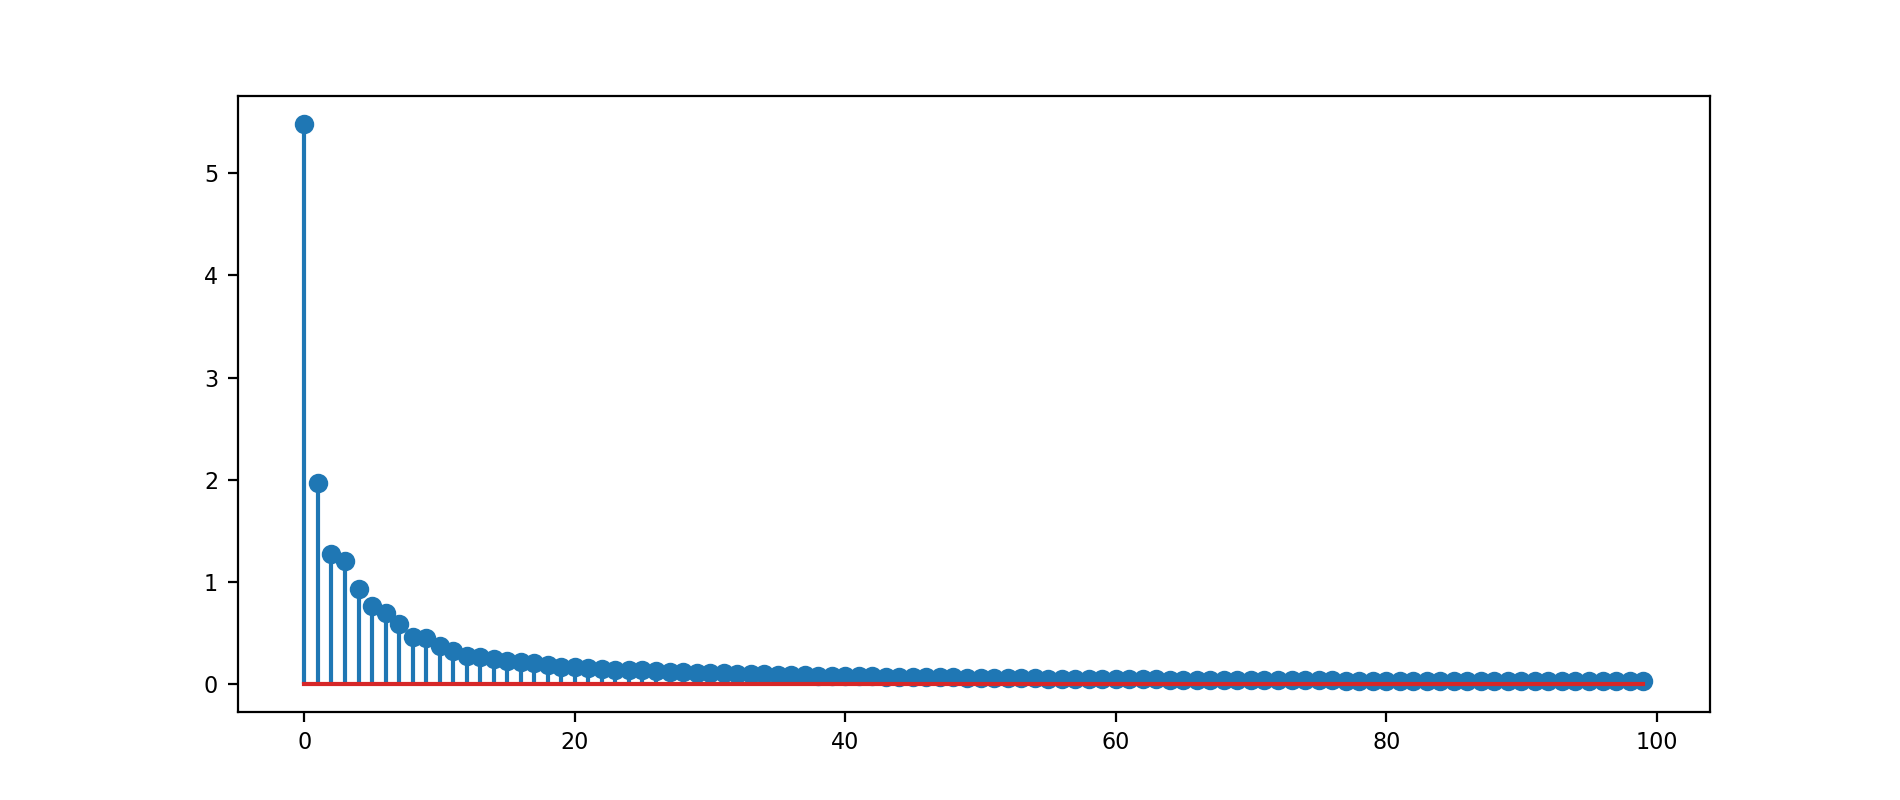

<StemContainer object of 3 artists>

In [8]:
fig = plt.figure(figsize=(9.5,4))
ax = fig.add_subplot(111)
ax.stem(s[0:r_max]/n)

In [9]:
import ot
from tqdm import tqdm

def wasserstein_dim_select(Y, split = 0.5, rmin = 1, rmax = 50):
    n = Y.shape[0]
    train = round(n * split)
    rtry = int(np.min((train, rmax)))
    if sparse.issparse(Y):
        Y = Y.todense()
    Ytrain = Y[:train,:]
    Ytest = Y[train:n,:]
    U, s, Vh = sparse.linalg.svds(Ytrain,k=rtry-1) #as per paper
    #U, s, Vh = sparse.linalg.svds(Ytest,k=rtry-1)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    ws = []
    for r in tqdm(range(rmin,rtry+1)):
        P = Vh.T[:,:r] @ Vh[:r,:]
        Yproj = Ytrain @ P.T
        n1 = Yproj.shape[0]
        n2 = Ytest.shape[0]
        M = ot.dist(Yproj,Ytest, metric='euclidean')
        W1 = ot.emd2(np.repeat(1/n1,n1),np.repeat(1/n2,n2),M)
        ws.append(W1)
    return ws

In [10]:
rng = np.random.default_rng(seed=1)

In [11]:
#Wasserstein dimension selection - maybe slow if run on Y, if so instead run on zeta_r_max
rmin = 15
rmax = 70
ws = wasserstein_dim_select(Y=rng.permutation(Y), split=0.5, rmin=rmin, rmax=rmax)
dim = np.argmin(ws)+rmin
print(f'Number of dimensions selected: {dim}')


100%|███████████████████████████████████████████| 56/56 [00:00<00:00, 66.67it/s]

Number of dimensions selected: 36


<IPython.core.display.Javascript object>


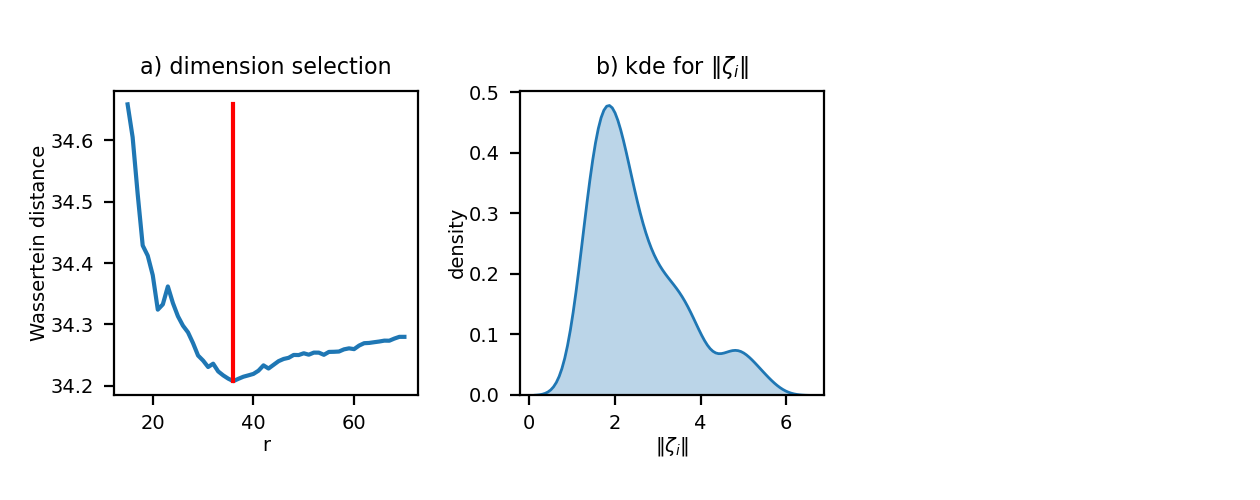

In [12]:
fig_3plots = plt.figure(figsize=(6.3,2.5))
ax = fig_3plots.add_subplot(131)
ax.plot(range(rmin,rmax+1),ws)
ax.plot([dim,dim], [min(ws),max(ws)], c='r')

fontsize = 7
titlesize = 8
labelpad = 0.7

ax.set_xlabel('r', fontsize=fontsize, labelpad=1)
ax.set_ylabel('Wassertein distance', fontsize=fontsize, labelpad=labelpad)
ax.tick_params(labelsize=fontsize)
ax.set_title(r"a) dimension selection", fontsize=titlesize)
ax.set_box_aspect(1)

In [140]:
plt.savefig('temps_3plots.png', dpi=300, format='png', bbox_inches='tight')

In [13]:
#dim = 20

zeta = zeta_r_max[:,0:dim] #keep the selected number of dimensions
zeta_inner_prods =   zeta @ zeta.T
zeta_mags = np.linalg.norm(zeta,axis = 1)
zeta_cos_sim = knl.cosine_similarity(zeta)

#correct numerical value to be in correct domain of arccos
zeta_cos_sim = np.maximum(zeta_cos_sim,-1)
zeta_cos_sim = np.minimum(zeta_cos_sim,1)
zeta_arc_dist = np.arccos(zeta_cos_sim)


In [14]:
ax = fig_3plots.add_subplot(132)
sns.kdeplot(x=zeta_mags, ax=ax, gridsize = 100, fill=True, alpha = 0.3)
ax.set_xlabel(r"$\|\zeta_i\|$", fontsize=fontsize, labelpad=labelpad )
ax.set_ylabel(r"density", fontsize=fontsize, labelpad=labelpad)
ax.set_title(r"b) kde for $\|\zeta_i\|$", fontsize=titlesize)
#ax.set_xlim([0, zeta_mags.max()])
ax.tick_params(labelsize=fontsize)
ax.set_box_aspect(1)


In [15]:
fig_3plots.tight_layout()

In [16]:
#get the k-nn graph and then use it to define a networkx graph
#k=10  for weather data
W = kneighbors_graph(zeta_arc_dist, n_neighbors=5, mode='distance', include_self=False, metric='precomputed')

#print(linalg.issymmetric(W.todense()))

G=nx.from_scipy_sparse_array(W, parallel_edges=False, create_using=nx.Graph, edge_attribute='weight')

#G_di=nx.from_scipy_sparse_array(W, parallel_edges=False, create_using=nx.DiGraph, edge_attribute='weight')
#G_check = G_di.to_undirected(reciprocal=False, as_view=False)  #forms undirected edge if directed edges is present in either direction
#print(G.edges == G_check.edges)

print("is emnbedding knn graph connected?")
print(nx.is_connected(G))

is emnbedding knn graph connected?
True


In [17]:
pos = {i:(lat_long[i,1],lat_long[i,0]) for i in range(n)}
pos_vals = np.array(list(pos.values()), dtype=float)


#compute geographic k-nn graph using straightline distance between lat long coords
W_pos = kneighbors_graph(pos_vals, n_neighbors=5, mode='distance', include_self=False)
G_pos=nx.from_scipy_sparse_array(W_pos, parallel_edges=False, create_using=nx.Graph, edge_attribute='weight')


print("is geographi knn graph connected? ")
print(nx.is_connected(G_pos))

is geographi knn graph connected? 
True


In [19]:
import os
import conda

#Basemap is a map plotting package
#the below is some kind of work around to get Basemap working with Anaconda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

<IPython.core.display.Javascript object>


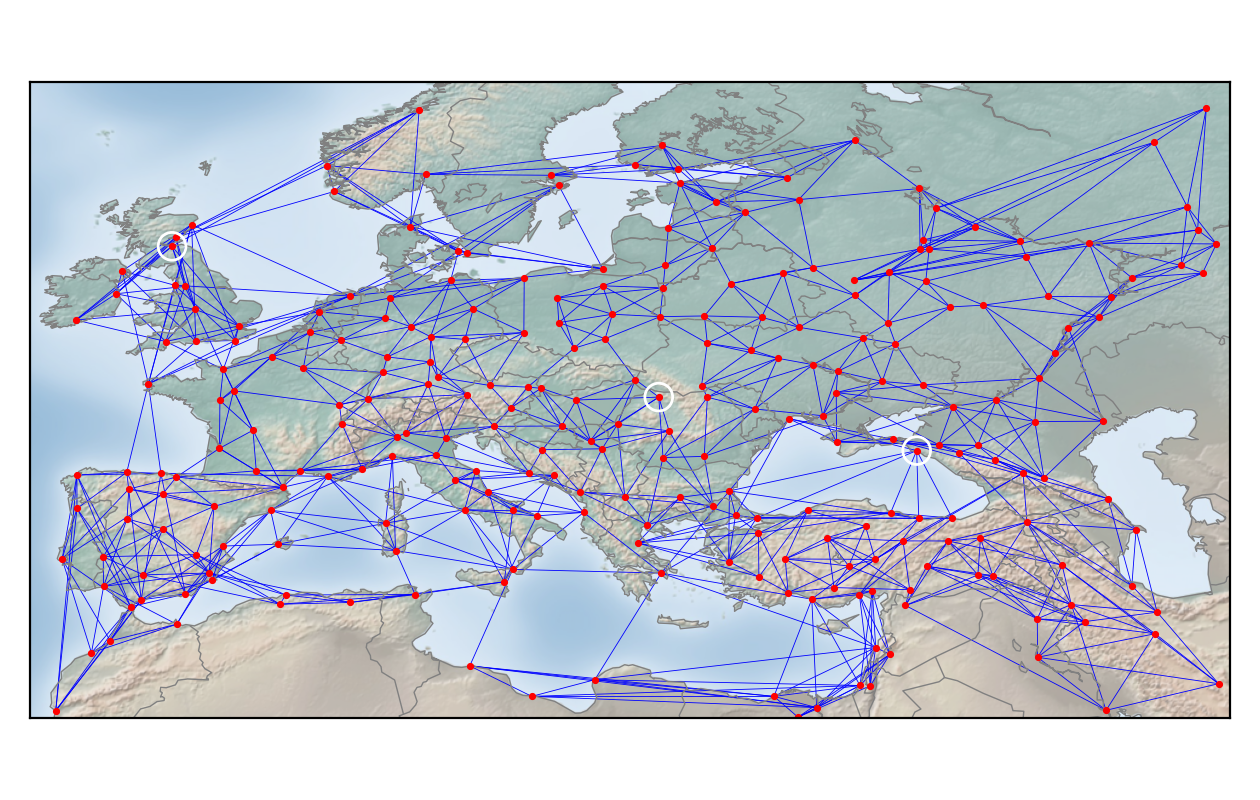

In [20]:
#draw a map using Basemap

fig = plt.figure(figsize=(6.3,4))
#Custom adjust of the subplots
#plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)

#europe only
# x1 = -11.
# x2 = 38.
# y1 = 33.
# y2 = 65.

x1 = -11.
x2 = 55.
y1 = 30.
y2 = 65.

#europe, africa and asia
# x1 = -20.
# x2 = 150.
# y1 = -40.
# y2 = 70.

m = Basemap(resolution='l',projection='cyl', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,lat_ts=(x1+x2)/2)
m.drawcountries(linewidth=0.5, color='0.5')
m.drawcoastlines(linewidth=0.5, color='0.5')
m.shadedrelief(alpha=0.8, scale = 0.5)#alpha = 0.3 for spline plot
#m.drawparallels(np.arange(35,70,10.),labels=[1,0,0,0],color='white',dashes=[1,0],labelstyle='+/-',linewidth=0) # draw parallels
#m.drawmeridians(np.arange(-10,50,10.),labels=[0,0,0,1],color='white',dashes=[1,0],labelstyle='+/-',linewidth=0); # draw meridians

fig.tight_layout()

In [21]:
#plot nearest neighbour graph on top of the map
pos = {i:(lat_long[i,1],lat_long[i,0]) for i in range(n)}
nx.draw_networkx_nodes(G,pos = pos, ax=ax, node_size=10, node_shape='.', alpha=1, node_color='r')
nx.draw_networkx_edges(G,pos = pos, ax=ax, alpha=1, width = 0.3, edge_color = 'b', arrows=False)
fig.tight_layout()

/tmp/ipykernel_29622/3023230013.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [22]:
#higghlight some cities

Edinburgh = np.where(cities_and_countries[ind_region,0]=="Edinburgh")[0][0]
Baia_Mare = np.where(cities_and_countries[ind_region,0]=="Baia Mare")[0][0]
Novorossiysk = np.where(cities_and_countries[ind_region,0]=="Novorossiysk")[0][0]

ax.scatter(lat_long[Edinburgh,1], lat_long[Edinburgh,0],  facecolors='none', edgecolors='w',
           linewidth = 1, s=100, marker='o', zorder = +100)
ax.scatter(lat_long[Baia_Mare,1], lat_long[Baia_Mare,0],  facecolors='none', edgecolors='w',
           linewidth = 1, s=100, marker='o', zorder = +100) 
ax.scatter(lat_long[Novorossiysk,1], lat_long[Novorossiysk,0],  facecolors='none', edgecolors='w',
           linewidth = 1, s=100, marker='o', zorder = +100) 


In [23]:
#have a look at their neighbours
print(cities[list(G[Edinburgh])])
print(cities[list(G[Baia_Mare])])
print(cities[list(G[Novorossiysk])])

['Basildon' 'Blackburn' 'Cork' 'Dublin' 'Dundee' 'Birmingham' 'Trondheim']
['Arad' 'Budapest' 'Novi Sad' 'Uzhhorod' 'Sibiu' 'Craiova']
['Ordu' 'Trabzon' 'Samsun' 'Istanbul' 'Burgas' 'Odesa']


In [64]:
plt.savefig("embedding_knn.png", format="png", dpi =200, bbox_inches='tight')

<IPython.core.display.Javascript object>


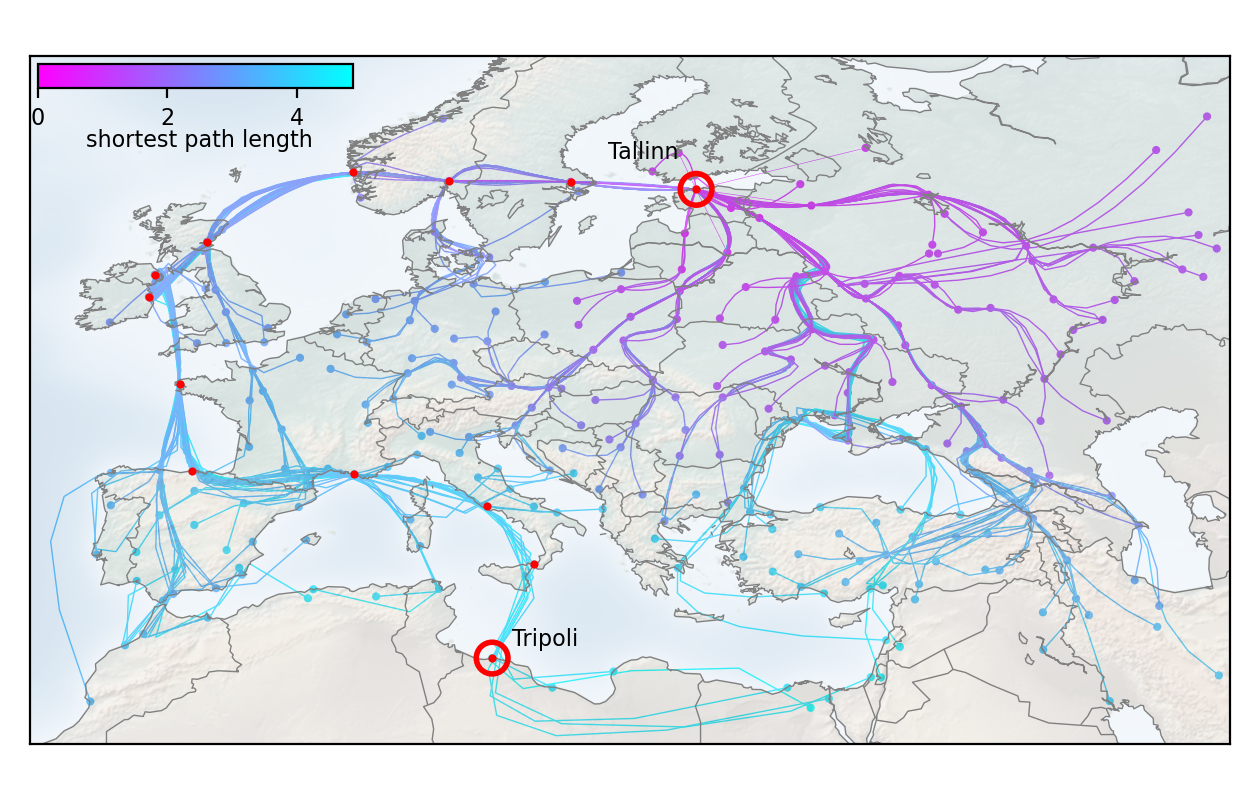

In [26]:
#draw a map using Basemap

fig = plt.figure(figsize=(6.3,4)) #figsize units are inches - A4 paper is 8.3x11.7in
#Custom adjust of the subplots
ax = plt.subplot(111)

x1 = -13.
x2 = 55.
y1 = 28.
y2 = 67.

#europe, africa and asia
# x1 = -20.
# x2 = 150.
# y1 = -40.
# y2 = 70.

m = Basemap(resolution='l',projection='cyl', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,lat_ts=(x1+x2)/2)
m.drawcountries(linewidth=0.5, color='0.5')
m.drawcoastlines(linewidth=0.5, color='0.5')
m.shadedrelief(alpha=0.3, scale = 0.5)#alpha = 0.3 for spline plot
#m.drawparallels(np.arange(35,70,10.),labels=[1,0,0,0],color='white',dashes=[1,0],labelstyle='+/-',linewidth=0) # draw parallels
#m.drawmeridians(np.arange(-10,50,10.),labels=[0,0,0,1],color='white',dashes=[1,0],labelstyle='+/-',linewidth=0); # draw meridians

fig.tight_layout()

In [25]:
# #plot geographic nearest neighbour graph 
# nx.draw_networkx_nodes(G_pos,pos = pos, ax=ax, node_size=10, node_shape='.', alpha=1, node_color='r')
# nx.draw_networkx_edges(G_pos,pos = pos, ax=ax, alpha=1, width = 0.2, edge_color = 'b', arrows=False)
# fig.tight_layout()

/tmp/ipykernel_29622/2604978787.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [238]:
# plt.savefig("geographic_knn.png", format="png", dpi =200, bbox_inches='tight')

In [27]:
#plot shortest paths using spline interpolation, with longest paths underneath shorter ones.

source_name = "Tallinn"

i_plot = range(n)

lengths = np.zeros(n)
source = np.where(cities_and_countries[ind_region,0]==source_name)[0][0] #Tallinn
#source = max(betweenness_dict, key=betweenness_dict.get)

for i in range(n):
    lengths[i] = nx.shortest_path_length(G, source=source, target=i, weight='weight')
    
order = np.argsort(lengths)

my_cmap = cm.cool_r
my_norm = colors.Normalize(vmin=lengths.min(), vmax=lengths.max())

for i in i_plot:
    path = nx.shortest_path(G, source=source, target=order[i], weight='weight')
  
    #spline interpolation
    x = lat_long[path,1]
    y = lat_long[path,0]
    k_spline = 2
    if len(path) > k_spline:
        #k_spline = min(len(path)-1,5) #order of spline  - second argument of min,
        tck, u = splprep([x,y], s=0, k=k_spline)
        unew = np.arange(0, 1.05, 0.05)
        out = splev(unew, tck)
        ax.plot(out[0], out[1], linewidth=0.5, color = my_cmap(my_norm(lengths[order[i]])),zorder = -i)
    elif len(path) > 1:
        ax.plot(x, y, linewidth=0.2, color = my_cmap(my_norm(lengths[order[i]])), zorder = -i)



In [28]:
#plot the cities and colour by geodesic distance    
sc = ax.scatter(lat_long[:,1], lat_long[:,0],  
                 c = lengths, vmin=min(lengths), vmax= max(lengths),
                 cmap = my_cmap, s=15, marker='.',  zorder = -550)
#or just make them all the same colour
#sc = ax.scatter(lat_long[:,1], lat_long[:,0],  
#                 c = 'b', s=30, marker='.',  zorder = -600)

#highlight and label the source city
ax.scatter(lat_long[source,1], lat_long[source,0],  facecolors='none', edgecolors='r',
           linewidth = 2, s=130, marker='o', zorder = +100) 
ax.text(x=pos[source][0]-5,y=pos[source][1]+1.7,s=source_name, size=titlesize)


cax = fig.add_axes([0.03, 0.89, 0.25, 0.03])
cb = fig.colorbar(sc, cax=cax, orientation='horizontal')
cb.ax.text(2.5, -2.2, s='shortest path length', ha='center',va='center', size=titlesize);



In [29]:
#extract a shortest path with end-point of interest
target_name = "Tripoli"
target = np.where(cities==target_name)[0][0]
path_s_to_t = nx.shortest_path(G, source=source, target=target, weight='weight')
print(cities[path_s_to_t])


['Tallinn' 'Uppsala' 'Oslo' 'Bergen' 'Dundee' 'Dublin' 'Belfast' 'Brest'
 'Santander' 'Marseille' 'Latina' 'Messina' 'Tripoli']


In [30]:
#highlight the intermediate cities in the path
ax.scatter(lat_long[target,1], lat_long[target,0],  facecolors='none', edgecolors='r',
           linewidth = 2, s=130, marker='o', zorder = +100) 
ax.text(x=pos[target][0]+1.1,y=pos[target][1]+0.7,s=target_name, size=titlesize)

ax.scatter(lat_long[path_s_to_t,1], lat_long[path_s_to_t,0],  s=15, marker='.', c='r', zorder = +100)


In [60]:
plt.savefig("geodesics_tallinn.png", format="png", dpi =200,bbox_inches='tight')
